In [1]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [2]:
X_dim = 6
c_dim = 21
occ_dim = 121
y_dim = X_dim
z_dim = 3

bs = 256

## 读取dataset

In [3]:
from data.NarrowPassDataset import NarrowPassDataset

train_loader = DataLoader(NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = True),
                         batch_size = bs, shuffle=True)
test_loader = DataLoader(NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = True), 
                         batch_size = bs, shuffle=True)

## 定义模型

In [4]:
from models.CVAE import CVAE

model = CVAE(sample_size = 6, 
                  condition_size = 21, 
                  encoder_layer_sizes = [512,512], 
                  latent_size = 3, 
                  decoder_layer_sizes = [512,512]).to(device)
print(model)

CVAE(
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Linear(in_features=27, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
    (linear_means): Linear(in_features=512, out_features=3, bias=True)
    (linear_log_var): Linear(in_features=512, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (sequential): Sequential(
      (0): Linear(in_features=24, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=6, bias=True)
    )
  )
)


## loss function, optimizer

In [5]:
def loss_fn(recon_x, x, w, mean, log_var):
    MSE = torch.mean((w.expand_as(x) * (recon_x-x)**2))
    KLD = - 0.0002 * torch.mean(torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), 1))
    return MSE + KLD, MSE

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 训练

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    mse_loss = 0
    w = torch.tensor([1, 1, 1, 0.5, 0.5, 0.5], dtype=torch.float).to(device)
    for batch_idx, (sample, condition, _) in enumerate(train_loader):
        
        sample, condition = sample.to(device), condition.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(sample, condition)
        loss, mse= loss_fn(recon_batch, sample, w, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    epoch_loss = train_loss * len(sample) / len(train_loader.dataset)
    epoch_mse = mse_loss * len(sample) / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.7f}'.format(
          epoch, epoch_loss))
    return epoch, epoch_loss, epoch_mse

In [7]:
epoch = 0
# bash: python -m visdom.server
from visdom import Visdom
vis = Visdom(env='gap_shadow')

loss_window = vis.line(
    Y=torch.zeros((2)).cpu(),
    X=torch.zeros((2)).cpu(),
    opts=dict(xlabel='epoch',ylabel='Loss',title='training loss',legend=['loss']))

In [8]:
for epoch in range(epoch, epoch + 500):
    log_interval = 100
    epoch, epoch_loss, epoch_mse = train(epoch)
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_loss]).unsqueeze(0).cpu(),win=loss_window,update='append',name='loss')
    vis.line(X=torch.ones((1,1)).cpu()*epoch,Y=torch.Tensor([epoch_mse]).unsqueeze(0).cpu(),win=loss_window,update='append',name='mse_loss')
    

Train Epoch: 0 [0/66984 (0%)]	Loss: 0.235219
Train Epoch: 0 [25600/66984 (38%)]	Loss: 0.019374
Train Epoch: 0 [51200/66984 (76%)]	Loss: 0.016603
====> Epoch: 0 Average loss: 0.0182468
Train Epoch: 1 [0/66984 (0%)]	Loss: 0.014415
Train Epoch: 1 [25600/66984 (38%)]	Loss: 0.015373
Train Epoch: 1 [51200/66984 (76%)]	Loss: 0.013434
====> Epoch: 1 Average loss: 0.0093025
Train Epoch: 2 [0/66984 (0%)]	Loss: 0.012291
Train Epoch: 2 [25600/66984 (38%)]	Loss: 0.011876
Train Epoch: 2 [51200/66984 (76%)]	Loss: 0.012235
====> Epoch: 2 Average loss: 0.0082685
Train Epoch: 3 [0/66984 (0%)]	Loss: 0.012433
Train Epoch: 3 [25600/66984 (38%)]	Loss: 0.011735
Train Epoch: 3 [51200/66984 (76%)]	Loss: 0.011358
====> Epoch: 3 Average loss: 0.0075299
Train Epoch: 4 [0/66984 (0%)]	Loss: 0.010877
Train Epoch: 4 [25600/66984 (38%)]	Loss: 0.010285
Train Epoch: 4 [51200/66984 (76%)]	Loss: 0.010136
====> Epoch: 4 Average loss: 0.0069654
Train Epoch: 5 [0/66984 (0%)]	Loss: 0.010774
Train Epoch: 5 [25600/66984 (38%)]	

## 可视化结果

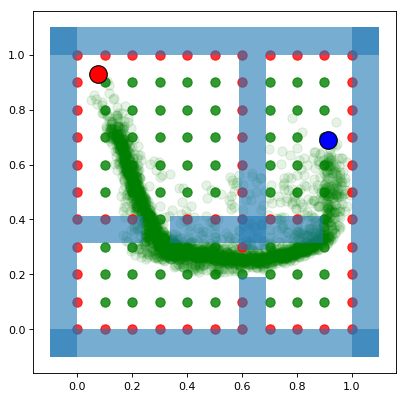

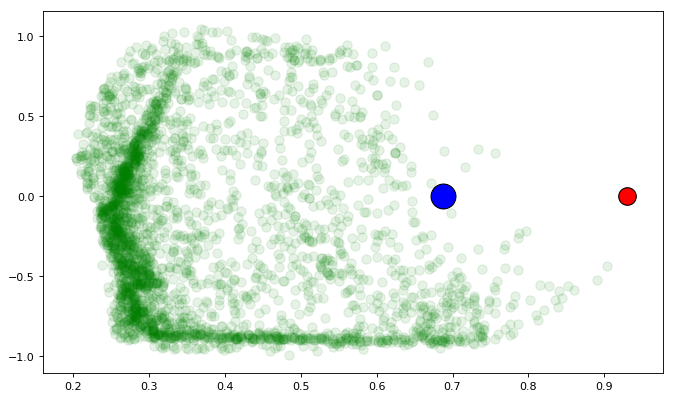

In [11]:
test_data = NarrowPassDataset(csv_file = "data/NarrowPassage/narrowDataOcc.txt",
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            occ_dim = occ_dim,
                            train = False)
viz_idx =   torch.randint(0,len(test_data),[1]).item()  

viz_idx = 8712

_, condition, _ = test_data[viz_idx]
condition = torch.tensor(condition)
model.eval()
num_viz = 3000
y_viz = model.decode(torch.cat((torch.randn(num_viz, z_dim).to(device),
                                condition.expand(num_viz, -1).to(device)),
                               dim=-1))

y_viz=y_viz.cpu().detach().numpy()
condition=condition.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed

# plotCondition(condition)
plotSample(y_viz, condition)
plotSpeed(y_viz, condition)